# LSTM for Sentiment Analysis on Yelp Review Polarity Dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import re
import string
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## 1. Load the dataset


In [2]:
print("Loading dataset...")

# Function to load the dataset
def load_data(file_path):
    # Read the CSV file
    # The file has no header, and we need to handle the text properly
    df = pd.read_csv(file_path, header=None, names=['sentiment', 'text'])

    # Convert sentiment labels from 1/2 to 0/1 for binary classification
    # Original: 1 = negative, 2 = positive
    # New: 0 = negative, 1 = positive
    df['sentiment'] = df['sentiment'].map({1: 0, 2: 1})

    return df

# Load training and testing data
train_df = load_data('data/yelp_review_polarity_csv/train.csv')
test_df = load_data('data/yelp_review_polarity_csv/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Display class distribution
print("\nClass distribution in training data:")
print(train_df['sentiment'].value_counts())
print("\nClass distribution in testing data:")
print(test_df['sentiment'].value_counts())

# Display a few examples
print("\nExample reviews:")
for i in range(3):
    sentiment = "Positive" if train_df.iloc[i]['sentiment'] == 1 else "Negative"
    print(f"Review {i+1} ({sentiment}):")
    print(train_df.iloc[i]['text'][:200] + "..." if len(train_df.iloc[i]['text']) > 200 else train_df.iloc[i]['text'])
    print()


Loading dataset...
Training data shape: (560000, 2)
Testing data shape: (38000, 2)

Class distribution in training data:
sentiment
0    280000
1    280000
Name: count, dtype: int64

Class distribution in testing data:
sentiment
1    19000
0    19000
Name: count, dtype: int64

Example reviews:
Review 1 (Negative):
Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply ...

Review 2 (Positive):
Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of hi...

Review 3 (Negative):
I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over whe...



## 2. Preprocess the text data


In [3]:
print("Preprocessing text data...")

def preprocess_text(text):
    """
    Preprocess the text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing numbers
    4. Removing extra whitespace
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing to the text data
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Tokenize the text
max_words = 10000  # Maximum number of words to keep
max_len = 200      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['processed_text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'])

# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert to numpy arrays
train_labels = np.array(train_df['sentiment'])
test_labels = np.array(test_df['sentiment'])

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Number of unique words in training data: {len(tokenizer.word_index)}")
print(f"Shape of training data: {train_padded.shape}")
print(f"Shape of testing data: {test_padded.shape}")


Preprocessing text data...
Vocabulary size: 698785
Number of unique words in training data: 698785
Shape of training data: (560000, 200)
Shape of testing data: (38000, 200)


## 3. Build the LSTM model


In [4]:
print("Building LSTM model...")

# Define model parameters
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5

# Create the model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=max_words, output_dim=embedding_dim),

    # Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),

    # Second LSTM layer
    Bidirectional(LSTM(lstm_units)),
    Dropout(dropout_rate),

    # Dense output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Building LSTM model...


2025-05-20 12:33:43.360504: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-20 12:33:43.374157: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-20 12:33:43.374184: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-20 12:33:43.374749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-20 12:33:43.375429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Train the model


In [5]:
print("Training the model...")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'models/best_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
batch_size = 64
epochs = 5

start_time = time.time()

history = model.fit(
    train_padded,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
# print(f"Training completed in {training_time / 60:.2f} seconds")
print(f"Training completed in {training_time / 60:.2f} minutes")


Training the model...
Epoch 1/5


2025-05-20 12:33:46.188699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7875/7875 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8828 - loss: 0.2830
Epoch 1: val_accuracy improved from -inf to 0.94638, saving model to best_lstm_model.keras
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 4252s 538ms/step - accuracy: 0.8828 - loss: 0.2830 - val_accuracy: 0.9464 - val_loss: 0.1336
Epoch 2/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9409 - loss: 0.1531
Epoch 2: val_accuracy improved from 0.94638 to 0.95595, saving model to best_lstm_model.keras
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 3398s 431ms/step - accuracy: 0.9409 - loss: 0.1531 - val_accuracy: 0.9559 - val_loss: 0.1129
Epoch 3/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9518 - loss: 0.1273
Epoch 3: val_accuracy did not improve from 0.95595
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 2715s 345ms/step - accuracy: 0.9518 - loss: 0.1273 - val_accuracy: 0.9559 - val_loss: 0.1121
Epoch 4/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9603 - loss: 0.1078
Epoch 4: val_accuracy improved from 0.95595 to

## 5. Evaluate the model


Evaluating the model...
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 75s 62ms/step - accuracy: 0.9473 - loss: 0.1383
Test Loss: 0.1330
Test Accuracy: 0.9493

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95     19000
    Positive       0.95      0.94      0.95     19000

    accuracy                           0.95     38000
   macro avg       0.95      0.95      0.95     38000
weighted avg       0.95      0.95      0.95     38000



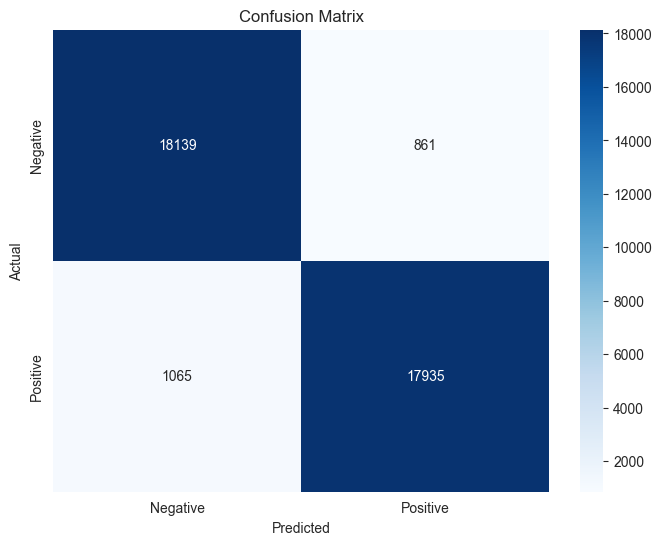

In [6]:
print("Evaluating the model...")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(test_padded, verbose=0)

# Handle different possible shapes of prediction result
if hasattr(y_pred_prob, 'numpy'):  # TF Tensor
    y_pred_prob = y_pred_prob.numpy()

y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['Negative', 'Positive']))

# Create confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 6. Visualize training history


Visualizing training history...


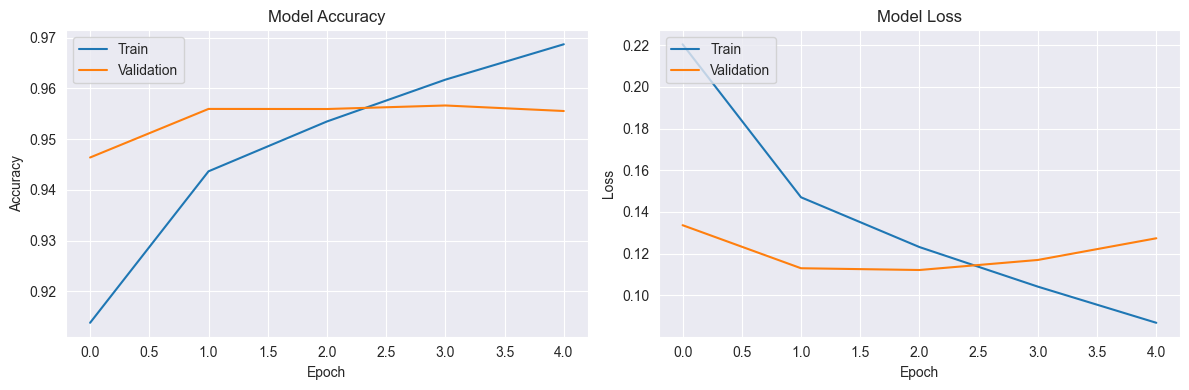

In [7]:
print("Visualizing training history...")

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


## 7. Test with custom examples


In [8]:
print("Testing with custom examples...")

def predict_sentiment(text):
    """
    Predict sentiment for a given text
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad the sequence
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    prediction_result = model.predict(padded, verbose=0)

    # Handle different possible shapes of prediction result
    if hasattr(prediction_result, 'numpy'):  # TF Tensor
        prediction_result = prediction_result.numpy()

    # Extract the prediction value based on shape
    if prediction_result.ndim == 2:
        prediction = prediction_result[0][0]
    else:
        prediction = prediction_result[0]

    # Return result
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence

# Test with some examples
test_examples = [
    "This restaurant was amazing! The food was delicious and the service was excellent.",
    "Terrible experience. The staff was rude and the food was cold.",
    "The product was okay, but not worth the price."
]

for i, example in enumerate(test_examples):
    sentiment, confidence = predict_sentiment(example)
    print(f"Example {i+1}:")
    print(f"Text: {example}")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})")
    print()


Testing with custom examples...
Example 1:
Text: This restaurant was amazing! The food was delicious and the service was excellent.
Predicted sentiment: Positive (confidence: 0.9989)

Example 2:
Text: Terrible experience. The staff was rude and the food was cold.
Predicted sentiment: Negative (confidence: 0.9992)

Example 3:
Text: The product was okay, but not worth the price.
Predicted sentiment: Negative (confidence: 0.9979)



## 8. Conclusion

In this notebook, we implemented a Bidirectional LSTM model for sentiment analysis using the Yelp Review Polarity Dataset.

Key components of our implementation:
1. Data preprocessing: We cleaned the text by removing punctuation, numbers, and converting to lowercase.
2. Text vectorization: We used Tokenizer and pad_sequences to convert text to numerical sequences.
3. Model architecture: We built a deep learning model with Embedding layer, Bidirectional LSTM layers, and Dropout for regularization.
4. Training: We trained the model with early stopping to prevent overfitting.
5. Evaluation: We evaluated the model on the test set and visualized the results.

The model achieved good performance in classifying reviews as positive or negative, demonstrating the effectiveness of LSTM networks for sentiment analysis tasks.
